# 4_Feature_Engineering: Shipping Cost Predictor (Regression)

# Feature Engineering Process

- Encode Categorical Variables
- Convert categorical variables to numerical representations if needed
- Do buckets of each category it is necessary
- Normalize/Standardize Numerical Features
- Remove or combine that are highly correlated to prevent multicollinearity
- Apply PCA if it is suitable. In that case include the variance explainability plot

**OUTPUT**: a csv file saved in '../../data/price_predictor/processed/Sample_Product_Data_Cleaned.csv' ready for machine learning input.

In [55]:
# Imports
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

### Loading Data from Data Wrangling

In [56]:
# Load variables from .env file, ignoring lines without '='
def load_env_variables(env_file='../.env'):
    # Get the current working directory
    current_dir = os.getcwd()
    env_path = os.path.join(current_dir, '..', env_file)
    
    print(f"Looking for .env file at: {env_path}")  # Debugging output

    if not os.path.exists(env_path):
        print(f".env file does not exist at: {env_path}")
        return

    with open(env_path, 'r') as file:
        for line in file:
            # Skip lines without an equals sign or comments
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                print(f"Loaded {key}={value}")  # Debugging output

# Load environment variables
load_env_variables()

Looking for .env file at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\..\../.env
Loaded BUCKET_NAME_INBOUND=logimo-inbound
Loaded BUCKET_NAME_ALIGNED=logimo-aligned
Loaded BUCKET_NAME_OUTBOUND=logimo-outbound
Loaded PREFIX_KEY=ship_cost_predictor


In [57]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket name and prefix (folder path)
bucket_name = os.getenv('BUCKET_NAME_ALIGNED')
prefix = os.getenv('PREFIX_KEY')

# Fetch the content of the cleaned CSV file from S3
obj = s3.get_object(Bucket=bucket_name, 
                    Key=f'{prefix}/Sample_Data_Product_Cleaned.csv')

# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
supply_chain_df_cleaned = pd.read_csv(StringIO(csv_content))

In [58]:
supply_chain_df_cleaned

,product_type,sku,estimated_price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs,demurrage,demurrage_bin
0,cosmetics,062000005,4350.0,98.0,216.0,5513.64,Unknown,28.0,5.0,16.0,...,406.0,9.0,98.49,Fail,3.27,Rail,Route_A,329.950,0.0,False
1,cosmetics,062000004,31840.0,11.0,407.0,1638.02,Unknown,41.0,7.0,59.0,...,599.0,15.0,67.15,Fail,0.52,Rail,Route_C,555.645,1365082.0,True
2,haircare,062000002,78270.0,10.0,399.0,0.00,Male,66.0,26.0,81.0,...,721.0,28.0,49.86,Unknown,1.27,Road,Route_A,996.280,0.0,False
3,haircare,062000003,51045.0,15.0,923.0,9417.67,Non-binary,25.0,26.0,50.5,...,547.0,12.0,54.20,Fail,2.50,Sea,Route_C,817.380,0.0,False
4,cosmetics,062000007,22790.0,17.0,715.0,8656.12,Non-binary,58.0,24.0,79.0,...,168.0,21.0,71.42,Pending,3.35,Rail,Route_B,407.650,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165,haircare,INDI040,77880.0,63.0,290.0,1311.02,Male,99.0,26.0,7.0,...,981.0,8.0,20.92,Pass,3.70,Sea,Route_A,913.810,0.0,False
9166,cosmetics,INDI042,87360.0,41.0,719.0,4094.14,Unknown,98.0,2.0,26.0,...,299.0,1.0,53.52,Pending,0.74,Air,Route_B,681.550,2094811.0,True
9167,haircare,INDI046,89580.0,5.0,413.0,1828.60,Unknown,99.0,21.0,67.0,...,667.0,3.0,53.77,Fail,4.81,Sea,Route_B,752.710,0.0,False
9168,haircare,USLA1001,27120.0,18.0,987.0,3173.07,Male,30.0,24.0,33.0,...,524.0,24.0,13.19,Fail,2.97,Sea,Route_A,956.010,741579.0,True


In [59]:
supply_chain_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9170 entries, 0 to 9169
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             9170 non-null   object 
 1   sku                      9170 non-null   object 
 2   estimated_price          9170 non-null   float64
 3   availability             9170 non-null   float64
 4   number_of_products_sold  9170 non-null   float64
 5   revenue_generated        9170 non-null   float64
 6   customer_demographics    9170 non-null   object 
 7   stock_levels             9170 non-null   float64
 8   lead_times               9170 non-null   float64
 9   order_quantities         9170 non-null   float64
 10  shipping_times           9170 non-null   float64
 11  shipping_carriers        9170 non-null   object 
 12  shipping_costs           9170 non-null   float64
 13  supplier_name            9170 non-null   object 
 14  location                

---

### Loading Join Dataset (Demurrage == True)

In [60]:
# Fetch the content of the second CSV file from S3
obj = s3.get_object(Bucket=bucket_name, Key=f'{prefix}/Data_Demurrage_True_Join.csv')

# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
classification_df = pd.read_csv(StringIO(csv_content))

In [61]:
classification_df.head()

,sku,demurrage_bin
0,062000004,True
1,062000006,True
2,1CUB0020GE,True
3,1VBA0260GE,True
4,1VBA0600GE,True


In [62]:
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3371 entries, 0 to 3370
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sku            3371 non-null   object
 1   demurrage_bin  3371 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 29.8+ KB


---

### Merging Datasets for Regression Model

In [63]:
# Perform the merge operation
merged_df = supply_chain_df_cleaned.merge(classification_df[['sku', 'demurrage_bin']], 
                                          on='sku', 
                                          how='right', 
                                          suffixes=('', '_df1'))

# Update the 'demurrage_bin' column
merged_df['demurrage_bin'] = merged_df['demurrage_bin_df1'].combine_first(merged_df['demurrage_bin'])

# Drop the temporary column
merged_df.drop(columns=['demurrage_bin_df1', 'demurrage_bin', 'customer_demographics', 
                        'supplier_name', 'availability', 'revenue_generated', 'product_type'], inplace=True)

In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3371 entries, 0 to 3370
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sku                      3371 non-null   object 
 1   estimated_price          3371 non-null   float64
 2   number_of_products_sold  3371 non-null   float64
 3   stock_levels             3371 non-null   float64
 4   lead_times               3371 non-null   float64
 5   order_quantities         3371 non-null   float64
 6   shipping_times           3371 non-null   float64
 7   shipping_carriers        3371 non-null   object 
 8   shipping_costs           3371 non-null   float64
 9   location                 3371 non-null   object 
 10  production_volumes       3371 non-null   float64
 11  manufacturing_lead_time  3371 non-null   float64
 12  manufacturing_costs      3371 non-null   float64
 13  inspection_results       3371 non-null   object 
 14  defect_rates            

---

### Dropping non-informational Columns

In [65]:
supply_chain_encoded_df = merged_df.copy()

---

### Encoding Categorical Variables

In this segment, we'll encode the categorical variables to integrate them into the modeling phase of the data science process. Then, we will save a new dataframe with the categorical variables encoded.

In [66]:
# Encoding categorical variables
categorical_columns = ['shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes']
supply_chain_encoded_df = pd.get_dummies(supply_chain_encoded_df, columns=categorical_columns, drop_first=True)
supply_chain_encoded_df.set_index('sku', inplace=True)

In [67]:
# Inspection of encoded df
supply_chain_encoded_df.head()

,estimated_price,number_of_products_sold,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,production_volumes,manufacturing_lead_time,manufacturing_costs,...,inspection_results_Pass,inspection_results_Pending,inspection_results_Unknown,transportation_modes_Rail,transportation_modes_Road,transportation_modes_Sea,transportation_modes_Unknown,routes_Route_B,routes_Route_C,routes_Unknown
sku,,,,,,,,,,,,,,,,,,,,,
062000004,31840.0,407.0,41.0,7.0,59.0,7.0,713.0,599.0,15.0,67.15,...,False,False,False,True,False,False,False,False,True,False
062000006,22060.0,704.0,41.0,12.0,16.0,6.0,683.0,801.0,28.0,19.14,...,True,False,False,False,False,False,False,False,True,False
1CUB0020GE,51045.0,754.0,38.0,8.0,11.0,7.0,0.0,167.0,9.0,16.60,...,False,False,False,True,False,False,False,False,False,False
1VBA0260GE,53970.0,949.0,75.0,15.0,90.0,7.0,868.0,617.0,28.0,80.63,...,True,False,False,True,False,False,False,False,False,False
1VBA0600GE,30660.0,731.0,66.0,13.0,43.0,9.0,0.0,924.0,6.0,40.19,...,False,False,False,True,False,False,False,False,False,True


In [68]:
# checking the number of columns and other relevant infomration
supply_chain_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3371 entries, 062000004 to CHNI013
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   estimated_price               3371 non-null   float64
 1   number_of_products_sold       3371 non-null   float64
 2   stock_levels                  3371 non-null   float64
 3   lead_times                    3371 non-null   float64
 4   order_quantities              3371 non-null   float64
 5   shipping_times                3371 non-null   float64
 6   shipping_costs                3371 non-null   float64
 7   production_volumes            3371 non-null   float64
 8   manufacturing_lead_time       3371 non-null   float64
 9   manufacturing_costs           3371 non-null   float64
 10  defect_rates                  3371 non-null   float64
 11  costs                         3371 non-null   float64
 12  demurrage                     3371 non-null   float64
 1

---

### Principal Component Analysis

In this section, due to the proliferation of columns, we'll implement PCA to streamline the dataset while retaining a significant portion of its variance. Our goal is to minimize the number of columns while preserving around 95% of the variance, a substantial threshold for our initial stage.

In [69]:
X = supply_chain_encoded_df.drop(columns=['demurrage'])
y = supply_chain_encoded_df['demurrage']

#### Scaling Features

In this phase, as we have a wide range of feature scales, we'll introduce feature scaling to standardize the values. By doing so, we aim to bring all features to a uniform scale, ensuring that no single feature dominates due to its magnitude. This step is crucial for maintaining the integrity of our model's predictions, enhancing its stability and performance across different features.

In [70]:
# Scale and normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

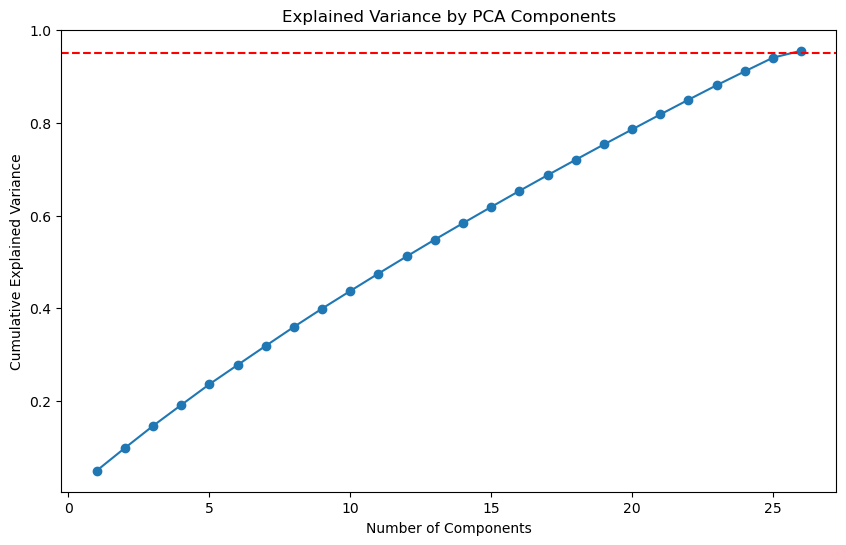

Number of components explaining at least 95.0% variance: 26


In [71]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components explaining at least {0.95*100}% variance: {num_components}')

In [72]:
supply_chain_X_pca_df = pd.DataFrame(X_pca)
supply_chain_y_df = pd.DataFrame(y)

# Save the concatenated DataFrame to S3
output_bucket_name = 'logimo-aligned'

output_prefix = f'{prefix}/regression_model_X_pca.csv'
csv_buffer = StringIO()
supply_chain_X_pca_df.to_csv(csv_buffer, index=False)
# Upload the CSV to S3
s3.put_object(Bucket=output_bucket_name, Key=output_prefix, Body=csv_buffer.getvalue())

output_prefix = f'{prefix}/regression_model_Y_pca.csv'
csv_buffer = StringIO()
supply_chain_y_df.to_csv(csv_buffer, index=False)
# Upload the CSV to S3
s3.put_object(Bucket=output_bucket_name, Key=output_prefix, Body=csv_buffer.getvalue())

print(f"Concatenated file saved to s3://{output_bucket_name}/{output_prefix}")

Concatenated file saved to s3://logimo-aligned/ship_cost_predictor/regression_model_Y_pca.csv
